In [11]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from alpha_vantage.timeseries import TimeSeries
from dotenv import load_dotenv
from datetime import datetime, timedelta

plt.style.use('seaborn-v0_8-whitegrid')

load_dotenv()

API_KEY = os.getenv('ALPHA_VANTAGE_API_KEY')

if not API_KEY:
    raise ValueError("Please set your Alpha Vantage API key")


In [12]:
def fetch_stock_data(symbol, outputsize='compact'):
    try:
        ts = TimeSeries(
            key=API_KEY,
            output_format='pandas',
            indexing_type='date'
        )

        data, meta_data = ts.get_daily(
            symbol=symbol,
            outputsize=outputsize
        )

        data = data.rename(columns={
            '1. open': 'open',
            '2. high': 'high',
            '3. low': 'low',
            '4. close': 'close',
            '5. volume': 'volume'
        })

        data = data[['open', 'high', 'low', 'close', 'volume']]

        data = data.sort_index()

        print(f"Successfully fetched data for {symbol}")
        print(f"Date range: {data.index.min().date()} to {data.index.max().date()}")
        print(f"Total records: {len(data)}")

        return data

    except Exception as e:
        print(f"Error fetching data: {str(e)}")
        raise

def calculate_moving_averages(df, short_window=5, long_window=20):
    data = df.copy()

    data['ma_short'] = data['close'].rolling(window=short_window, min_periods=1).mean()
    data['ma_long'] = data['close'].rolling(window=long_window, min_periods=1).mean()

    return data

def generate_signals(df):
    data = df.copy(deep=True)

    data['signal'] = 0

    for i in range(1, len(data)):
        current_idx = data.index[i]
        prev_idx = data.index[i-1]

        if data.loc[current_idx, 'ma_short'] > data.loc[current_idx, 'ma_long'] and \
           data.loc[prev_idx, 'ma_short'] <= data.loc[prev_idx, 'ma_long']:
            data.loc[current_idx, 'signal'] = 1

        elif data.loc[current_idx, 'ma_short'] < data.loc[current_idx, 'ma_long'] and \
             data.loc[prev_idx, 'ma_short'] >= data.loc[prev_idx, 'ma_long']:
            data.loc[current_idx, 'signal'] = -1

    return data

def plot_strategy(df, symbol, short_window, long_window, last_n_days=None):
    if last_n_days:
        cutoff_date = df.index.max() - timedelta(days=last_n_days)
        data = df[df.index >= cutoff_date]
        title_suffix = f" (Last {last_n_days} Days)"
    else:
        data = df
        title_suffix = ""

    fig, ax = plt.subplots(figsize=(16, 10))

    # Plot prices and moving averages
    ax.plot(data.index, data['close'], label='Close Price', linewidth=2, color='blue', alpha=0.7)
    ax.plot(data.index, data['ma_short'], label=f'{short_window}-Day MA', linewidth=2, color='orange')
    ax.plot(data.index, data['ma_long'], label=f'{long_window}-Day MA', linewidth=2, color='green')

    buy_signals = data[data['signal'] == 1]
    ax.scatter(buy_signals.index, buy_signals['close'],
              label='BUY Signal', marker='^', color='g', s=100, zorder=5)

    # Plot SELL signals
    sell_signals = data[data['signal'] == -1]
    ax.scatter(sell_signals.index, sell_signals['close'],
              label='SELL Signal', marker='v', color='r', s=100, zorder=5)

    ax.set_title(f'{symbol} Price with {short_window}-Day and {long_window}-Day Moving Averages{title_suffix}',
                fontsize=16, pad=20)
    ax.set_xlabel('Date', fontsize=14, labelpad=10)
    ax.set_ylabel('Price', fontsize=14, labelpad=10)
    ax.legend(fontsize=12)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)

    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    plt.show()

Successfully fetched data for AAPL
Date range: 2025-04-21 to 2025-09-11
Total records: 100

Latest data with signals:


,close,ma_short,ma_long,signal
date,,,,
2025-08-28,232.56,229.456,224.2725,0
2025-08-29,232.14,230.332,225.7605,0
2025-09-02,229.72,230.844,227.0790,0
2025-09-03,238.47,232.676,228.8565,0
2025-09-04,239.78,234.534,230.1830,0
2025-09-05,239.69,235.960,231.1660,0
2025-09-08,237.88,237.108,231.5925,0
2025-09-09,234.35,238.034,231.9510,0
2025-09-10,226.79,235.698,231.8080,0


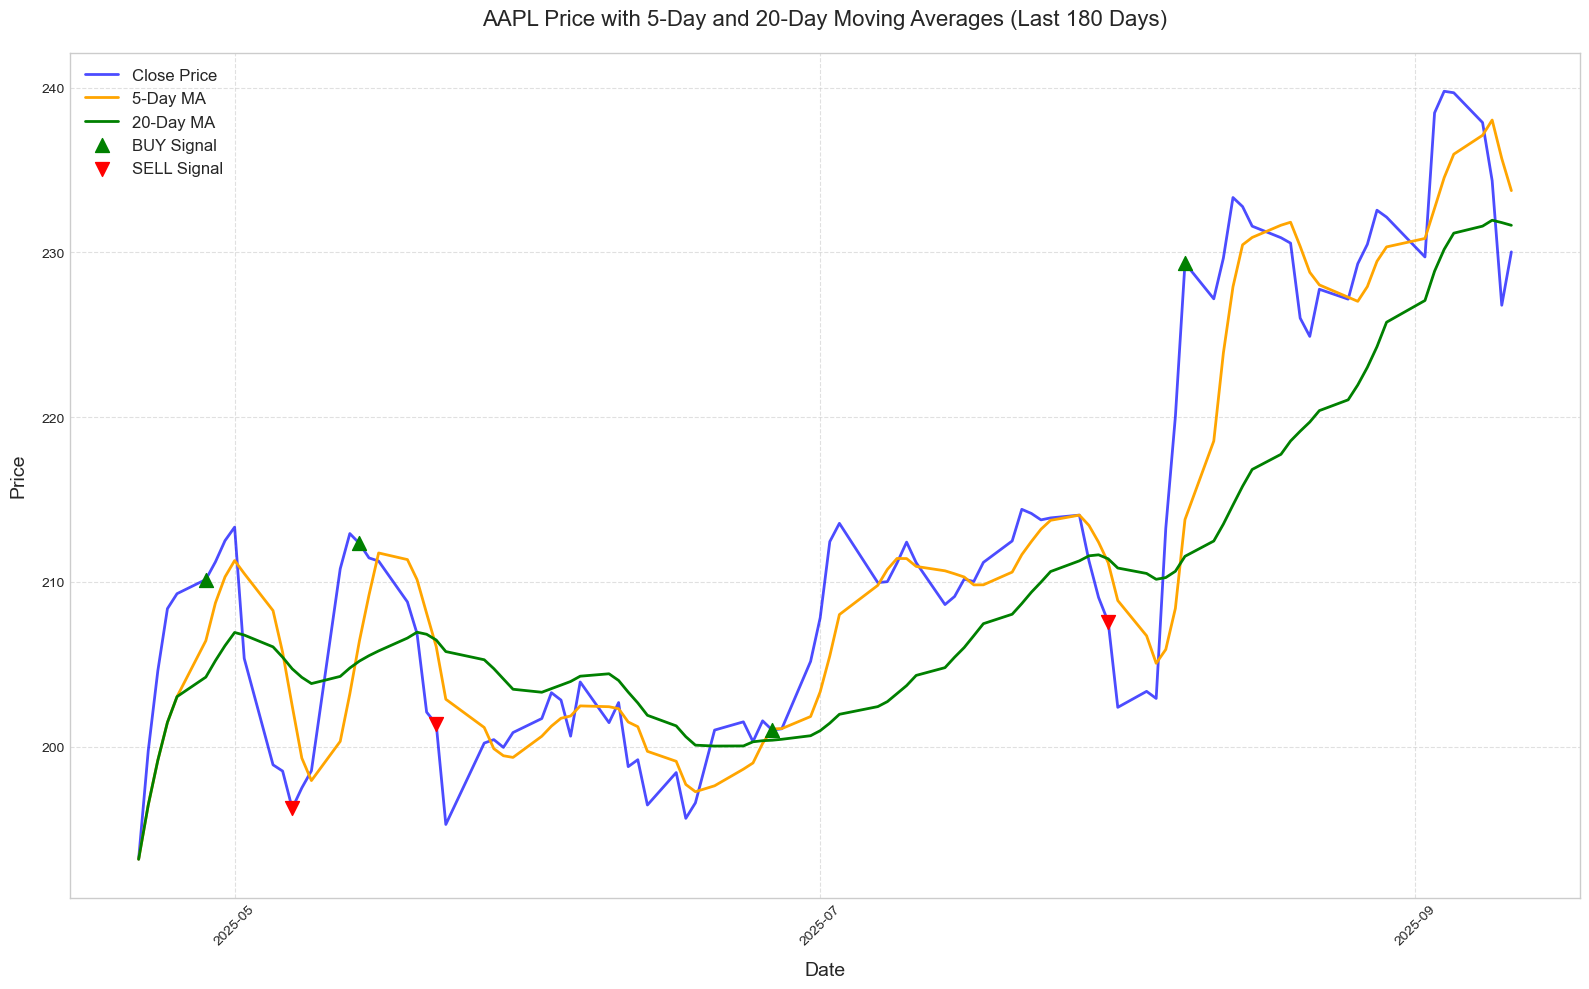

In [13]:
SYMBOL = "AAPL"  # Tencent Holdings
SHORT_WINDOW = 5     # 5-day moving average
LONG_WINDOW = 20     # 20-day moving average
LAST_N_DAYS = 180    # Plot only last 180 days for better visibility

stock_data = fetch_stock_data(SYMBOL)

stock_data_with_ma = calculate_moving_averages(
    stock_data,
    short_window=SHORT_WINDOW,
    long_window=LONG_WINDOW
)

stock_data_with_signals = generate_signals(stock_data_with_ma)

print("\nLatest data with signals:")
display(stock_data_with_signals[['close', 'ma_short', 'ma_long', 'signal']].tail(10))

plot_strategy(
    stock_data_with_signals,
    SYMBOL,
    SHORT_WINDOW,
    LONG_WINDOW,
    last_n_days=LAST_N_DAYS
)